In [34]:
import pandas as pd
import numpy as np
import cooler
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.patches import Patch
import scipy.io
from scipy.sparse import csgraph

from sklearn.decomposition import PCA
from scipy import stats
import networkx as nx
from sklearn.metrics import jaccard_score

import os
import sys
from importlib import reload

import filters
import imputation
import pore_c_utils as pcu
import binning_utils as binning
import plotting as hicPlot

In [3]:
assembly = pcu.loadAssembly("GRCm39_Assembly.txt")

chromDict = dict(zip(assembly['RefSeq accession'],assembly['Chromosome'].apply(lambda x : f"chr{x}")))

# the reverse for easy lookup
chromDict_r = {v: k for k, v in chromDict.items()}
chromOrder = list(chromDict.values())
chromOrder

['chr1',
 'chr2',
 'chr3',
 'chr4',
 'chr5',
 'chr6',
 'chr7',
 'chr8',
 'chr9',
 'chr10',
 'chr11',
 'chr12',
 'chr13',
 'chr14',
 'chr15',
 'chr16',
 'chr17',
 'chr18',
 'chr19',
 'chrX',
 'chrY']

In [4]:
# load the filtered pore-C data
dirpath = "/nfs/turbo/umms-indikar/shared/tools/Pore-C-Snakemake/results_ES5to12/contacts/"
cellNums = [1, 2, 4, 5, 6, 7] # dropping cell 3 due to sparsity
filetags = [f"run0{x}" for x in cellNums]

# filetags = [f"run0{x}" for x in range(1, 2)]

assembly = pcu.loadAssembly("GRCm39_Assembly.txt")
rawCells = pcu.loadRawContactDirectory(dirpath, filetags)

print("Filtering....")
filteredCells = filters.runAllFilters(rawCells,
                              assembly,
                              adjacent=False,
                              chromosome=None, 
                              verbose=False)  

print(f"\n{filteredCells.keys()=}")

runId='run01' df.shape=(13386738, 38)
runId='run02' df.shape=(13046898, 38)
runId='run04' df.shape=(20486346, 38)
runId='run05' df.shape=(5043403, 38)
runId='run06' df.shape=(7310826, 38)
runId='run07' df.shape=(10525887, 38)
Filtering....

filteredCells.keys()=dict_keys(['run01', 'run02', 'run04', 'run05', 'run06', 'run07'])


In [5]:
resolution = 1000000 # 1mb scale

totalLength = assembly['chromEnd'].max()
bins = binning.getBins(totalLength, resolution)

label1 = 'bin1'
label2 = 'bin2'

binnedData = {}
matrices = {}

for runId, data in filteredCells.items():
    binned = binning.wholeGenomeBinData(data, bins, label1, label2)
    binnedData[runId] = binned
      
    A = pcu.getHic(binned, bins, label1, label2)
    print(f"{runId=} {A.shape=}")
    matrices[runId] = A
    
print(f"{matrices.keys()}")

runId='run01' A.shape=(2724, 2724)
runId='run02' A.shape=(2724, 2724)
runId='run04' A.shape=(2724, 2724)
runId='run05' A.shape=(2724, 2724)
runId='run06' A.shape=(2724, 2724)
runId='run07' A.shape=(2724, 2724)
dict_keys(['run01', 'run02', 'run04', 'run05', 'run06', 'run07'])


In [6]:
newRows = []

for idx, row in assembly.iterrows():
    if "NC" in row['RefSeq accession']:
        
        start = binning.returnBin(row['chromStart'], bins) + 2
        end = binning.returnBin(row['chromEnd'], bins) + 3
        
        newRow = {
            'region' : f"chr{row['Chromosome']}",
            'start' : start,
            'end' : end,
            'length' : end - start,
        }
        
        newRows.append(newRow)
        
filteredChromInfo = pd.DataFrame(newRows)
filteredChromInfo

,region,start,end,length
0,chr1,1,197,196
1,chr2,196,378,182
2,chr3,377,538,161
3,chr4,537,695,158
4,chr5,694,847,153
5,chr6,846,996,150
6,chr7,995,1141,146
7,chr8,1140,1271,131
8,chr9,1270,1396,126
9,chr10,1395,1526,131


In [8]:
filteredPoreCIndex = list(range(0, len(matrices['run01'])))
print(f"{len(filteredPoreCIndex)=}")

len(filteredPoreCIndex)=2724


In [136]:

imputedNetworks = {}
chromosome = ['chr2']
tau = 0.5
alpha = 0.1


for runId, mat in matrices.items():
     
    ind = pcu.getIndices(filteredChromInfo, filteredPoreCIndex, chromosome, 'region')
    
    A = mat[:, ind][ind, :]
    
    # force diagonal 
    np.fill_diagonal(A, 1)
    
    # make sure no missing diag entries
    assert(np.any(np.diag(A) != 0))
    
    P = imputation.imputeContacts(A, tau, alpha)
    
    Aimp = A + P
    Aimp = np.where(Aimp > 0, 1, 0)
    print(f"{Aimp.shape=}")
    
    imputedNetworks[runId] = Aimp

print('done.')


Aimp.shape=(182, 182)
Aimp.shape=(182, 182)
Aimp.shape=(182, 182)
Aimp.shape=(182, 182)
Aimp.shape=(182, 182)
Aimp.shape=(182, 182)
done.


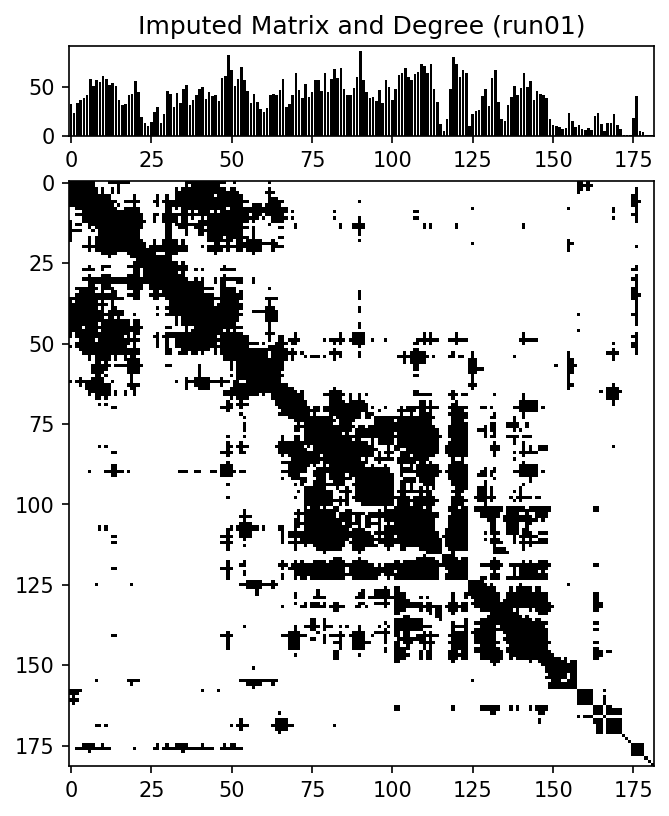

In [137]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 6, 6

for runId, A in imputedNetworks.items():
    
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.05

    hicPlotSize = [left, bottom, width, height]
    barPlotSize = [left, bottom + height + spacing, width, 0.1]

    fig = plt.figure()
    
    ax1 = fig.add_axes(hicPlotSize)
    ax1.imshow(A, cmap='binary')
    
    sumRows = np.sum(A, axis=0)

    ax2 = fig.add_axes(barPlotSize, sharex=ax1)
    ax2.bar(range(len(sumRows)), sumRows, color='k')
    
    ax2.set_title(f'Imputed Matrix and Degree ({runId})')
    
    plt.show()
    break

In [135]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 7, 2

for runId, A in imputedNetworks.items():
    print("--------")
    L = csgraph.laplacian(A, normed=True)
    w, v = np.linalg.eigh(L)
    
    eigs = [np.abs(round(i, 2)) for i in np.flip(w)]
    eps = 1.e-22
    zeroValuedEigs = np.sum(np.absolute(eigs) < eps)
    print(f"{runId=} {zeroValuedEigs=}")
    
    G = nx.from_numpy_array(A)
    print(f"{nx.is_connected(G)=}")

--------
runId='run01' zeroValuedEigs=7
nx.is_connected(G)=False
--------
runId='run02' zeroValuedEigs=7
nx.is_connected(G)=False
--------
runId='run04' zeroValuedEigs=40
nx.is_connected(G)=False
--------
runId='run05' zeroValuedEigs=23
nx.is_connected(G)=False
--------
runId='run06' zeroValuedEigs=17
nx.is_connected(G)=False
--------
runId='run07' zeroValuedEigs=16
nx.is_connected(G)=False


In [132]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 6, 6

for runId, A in imputedNetworks.items():

    print(A.shape)
    
    break

(182, 182)
